# **Emmanuel NYANDU KAGARABI**

# **Applied Machine Learning at scale : Practical 2 (Bias only)**

✅ Add user and item biases

✅ Add a sensible regularizer to your loss function

✅ Build a model that finds maximum likelihood estimate for user + item biases + latent trait vectors / factors with alternating least squares

✅ Plot the loss function (negative log likelihood) over training iterations. It should go down monotonically!

✅ Plot the root mean squared error over training iterations. What does it converge to?


# 0. Useful libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1.  Download the MovieLens 25M

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Practical1/ml-25m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
userId,25000095.0,8.118928e+04,4.679172e+04,1.0,4.051000e+04,8.091400e+04,1.215570e+05,1.625410e+05
movieId,25000095.0,2.138798e+04,3.919886e+04,1.0,1.196000e+03,2.947000e+03,8.623000e+03,2.091710e+05
rating,25000095.0,3.533854e+00,1.060744e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,25000095.0,1.215601e+09,2.268758e+08,789652009.0,1.011747e+09,1.198868e+09,1.447205e+09,1.574328e+09


In [ ]:
user_id = df['userId'].to_numpy(dtype=int)
movie_id = df['movieId'].to_numpy(dtype=int)
ratings = df['rating'].to_numpy(dtype=float)
df = pd.DataFrame({'userId': user_id, 'movieId': movie_id, 'rating': ratings})
df.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


# 2. Write a data structure that indexes the data (a) by user and (b) by movie

In [ ]:
# 1. Data structures
user_to_index ={} # ex {"u1":0,...,"u100": 99}
movie_to_index = {} # ex {"m1":0,...,"m50": 49}
list_to_user = [] # ex ["u1",...,"u100"]
list_to_movie = [] # ex ["m1",...,"m50"]
data_by_movie =  []# ex[[(u1,r10),...,(u100,r1100)],[...],[]]
data_by_user =  []# ex[[(m1,r10),...,(m50,r1100)],[...],[]]

# 2. Let's fill the data structure given above
for user,movie,rating in zip(user_id,movie_id,ratings):
    # Users
    if user not in user_to_index:
        index = len(list_to_user)
        user_to_index[user] = index
        list_to_user.append(user)
        data_by_user.append([])
    else:
        index = user_to_index[user]

    # Movies
    if movie not in movie_to_index:
        index_movie = len(list_to_movie)
        movie_to_index[movie] = index_movie
        list_to_movie.append(movie)
        data_by_movie.append([])
    else:
        index_movie = movie_to_index[movie]

    # Data
    data_by_movie[index_movie].append((index, rating))
    data_by_user[index].append((index_movie, rating))

# 3. ALS with bias only

In [ ]:
#Shapes
M = len(data_by_user) # Number of users
N = len(data_by_movie) # Number of movies

print(f"Number of users = {M}")
print(f"Number of movies = {N}")

Number of users = 162541
Number of movies = 59047


In [ ]:
# Parameters
lambda_ = 0.1  #
gamma = 0.01   #
max_iterations = 50

# Initialize biases
user_biases = np.zeros((M))
item_biases = np.zeros((N))

In [ ]:
# Helpers
# Function to get items and ratings for a given user
def get_items_and_ratings_for_user(user_index):
    return data_by_user[user_index] # ex output [(m1,r1),(m2,r2)]

# Function to get users and ratings for a given item
def get_users_and_ratings_for_item(item_index):
    return data_by_movie[item_index] #ex output [(u1,r1),(u2,r2)]

def compute_loss(data_by_user, user_bias, movie_bias, lambda_, gamma):
    cost = 0
    for user in range(len(data_by_user)):
        for (movie, rating) in data_by_user[user]:
            predicted_rating = user_bias[user] + movie_bias[movie]
            cost += (rating - predicted_rating) ** 2

    cost *= -0.5 * lambda_
    # user bias
    cost -= 0.5 * gamma * np.sum(user_bias**2 )
    # item_bias
    cost -= 0.5 * gamma  * np.sum(movie_bias**2)
     #log likelihood
    return cost

def rmse(data_by_user, user_biases, item_biases):
    squared_error = 0
    num_ratings = 0
    for m in range(len(data_by_user)):
        for (n, r) in data_by_user[m]:
            prediction = user_biases[m] + item_biases[n]
            squared_error += (r - prediction) ** 2
            num_ratings += 1
    rmse = np.sqrt(squared_error / num_ratings)
    return rmse

In [ ]:
losses = []
rmses = []

for iteration in range(max_iterations):

    #update use biases
    for m in range(M):
        bias = 0
        item_counter = 0
        for (n, r) in get_items_and_ratings_for_user(m):
            bias += lambda_ * (r - item_biases[n])
            item_counter += 1
        bias /= lambda_ * item_counter + gamma
        user_biases[m] = bias

    # Update item biases
    for n in range(N):
        bias = 0
        user_counter = 0
        for (m, r) in get_users_and_ratings_for_item(n):
            bias += lambda_ * (r - user_biases[m])
            user_counter += 1
        bias /= lambda_ * user_counter + gamma
        item_biases[n] = bias

    # Cost and rmse
    loss = compute_loss(data_by_user, user_biases, item_biases, lambda_, gamma)
    rmse_value = rmse(data_by_user, user_biases, item_biases)

    losses.append(loss)
    rmses.append(rmse_value)
    print(f"Iteration {iteration + 1}:\t Loss = {loss:.3f}\t  RMSE = {rmse_value:.3f}")

Iteration 1:	 Loss = -949129.408	  RMSE = 0.866
Iteration 2:	 Loss = -916426.389	  RMSE = 0.851
Iteration 3:	 Loss = -914868.836	  RMSE = 0.850
Iteration 4:	 Loss = -914751.776	  RMSE = 0.850
Iteration 5:	 Loss = -914726.044	  RMSE = 0.850
Iteration 6:	 Loss = -914709.593	  RMSE = 0.850
Iteration 7:	 Loss = -914694.640	  RMSE = 0.850
Iteration 8:	 Loss = -914680.005	  RMSE = 0.850
Iteration 9:	 Loss = -914665.457	  RMSE = 0.850
Iteration 10:	 Loss = -914650.949	  RMSE = 0.850
Iteration 11:	 Loss = -914636.469	  RMSE = 0.850
Iteration 12:	 Loss = -914622.015	  RMSE = 0.850
Iteration 13:	 Loss = -914607.586	  RMSE = 0.850
Iteration 14:	 Loss = -914593.183	  RMSE = 0.850
Iteration 15:	 Loss = -914578.805	  RMSE = 0.850
Iteration 16:	 Loss = -914564.453	  RMSE = 0.850
Iteration 17:	 Loss = -914550.125	  RMSE = 0.850
Iteration 18:	 Loss = -914535.823	  RMSE = 0.850
Iteration 19:	 Loss = -914521.546	  RMSE = 0.850
Iteration 20:	 Loss = -914507.293	  RMSE = 0.850
Iteration 21:	 Loss = -914493

In [ ]:
print(f"Negative loglikelihood converges to {losses[-1]:.3f}.")
print(f"RMSE converges to {rmses[-1]:.3f}.")

Negative loglikelihood converges to -914091.149.
RMSE converges to 0.850.


# 4. Negative log likelihood plot

In [ ]:
def plot_cost_vs_iter(train_costs, title="Evolution of Negative log likelihood over iterations"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='teal',linewidth=3, label='Negative log likelihood')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Negative log likelihood")
  ax.legend()
  plt.grid(linestyle='--', alpha=0.7)
  plt.savefig('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Practical1/ml-25m/log_bias.pdf', format='pdf')
  ax.set_title(title)
  plt.show()

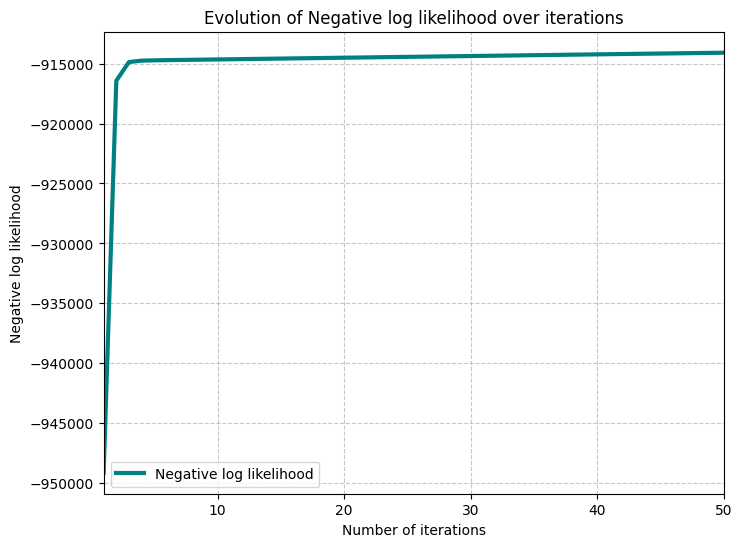

In [ ]:
plot_cost_vs_iter(losses)

# 5. RMSE plot

In [ ]:

def plot_rmse_vs_iter(train_rmse, title="Evolution of RMSE over iterations"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_rmse)+1)
  ax.plot(iters, train_rmse, color='teal',linewidth=3, label='RMSE')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("RMSE")
  ax.legend()
  plt.grid(linestyle='--', alpha=0.7)
  #plt.savefig('/home/emmanuelnk/Desktop/ML_AT_SCALE/Figures-20240509T064240Z-001/Figures/rmse_bias.pdf', format='pdf')
  plt.savefig('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Practical1/ml-25m/rmse_bias.pdf', format='pdf')
  ax.set_title(title)
  plt.show()

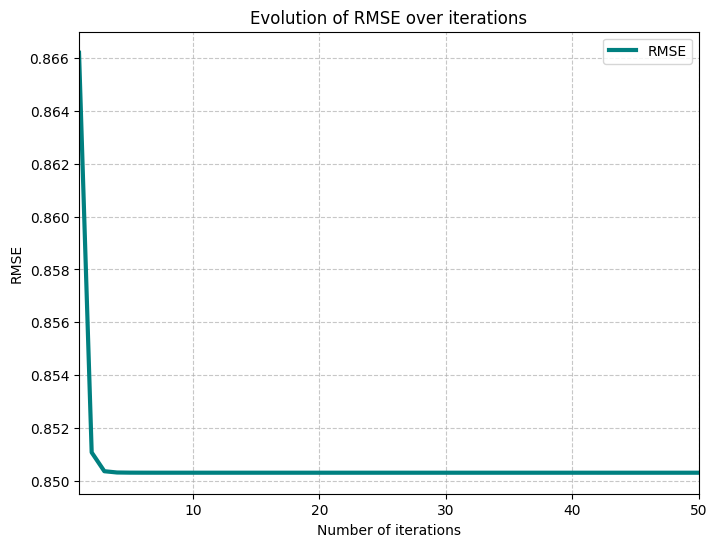

In [ ]:
plot_rmse_vs_iter(rmses)